In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import random 

In [2]:
def generate_exp_times(av_times, min_time):
    """
    It generates a list of lists of times with exponentially
    distributed intervals.
    Each list of times has an average specified in the av_times list.
    The total summation of time is larger than min_time.
    """
    tot_time = 0
    n_steps = int(1.5*min_time/np.mean(av_times)/len(av_times))
    while tot_time < min_time:
        exp_times = []
        tot_time = 0
        for av_time in av_times:
            exp_times_aux = np.random.exponential(av_time, n_steps)
            tot_time += np.sum(exp_times_aux)
            exp_times.append(exp_times_aux)
    return exp_times

def est_time(m, N, s):
    return 1/m/N/s
    
def sw_time(m, N, s):
    return np.log(N*s)/s

In [3]:
# States:
# 0 -> up concordant establishing
# 1- > up concordant switching
# 2 -> ab up discordant establishing
# 3- > ab up discordant switching
# 4 -> down concordant establishing
# 5- > down concordant switching
# 6 -> v up discordant establishing
# 7- > v up discordant switching

def generate_traj_telegr(est_t_r, est_t_v, sw_t_r, sw_t_v, min_time, start_s, dt=0.1):
    
    # Times of the trajectory
    times = generate_exp_times([est_t_v, sw_t_v, est_t_r, sw_t_r], min_time)
    # Map from a state to the index in the times 
    ind_map={0:0, 1:1, 2:2, 3:3, 4:0, 5:1, 6:2, 7:3}
    # Map from the state to the next state
    state_map={0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:0}
    
    traj = np.array([],dtype=int)
    t = 0
    s = start_s
    indexes = [0,0,0,0]
    for _ in range(len(times[0])*4):
        i = indexes[ind_map[s]]
        t += times[ind_map[s]][i]
        n_tot_steps = int(t/dt)
        n_steps = n_tot_steps - len(traj)
        new_traj = np.ones(n_steps)*s
        traj = np.append(traj, new_traj)
        indexes[ind_map[s]] += 1
        s = state_map[s]
    return  np.array(traj,dtype=int)

def generate_stat_state_telegr(est_t_r, est_t_v, sw_t_r, sw_t_v):
    ps = 1/np.array([sw_t_r/est_t_v, sw_t_r/sw_t_v, sw_t_r/est_t_r, 1, sw_t_r/est_t_v, sw_t_r/sw_t_v, sw_t_r/est_t_r, 1])
    return random.choices(np.arange(8),ps)

In [4]:
def generate_corr_telegr(est_t_r, est_t_v, sw_t_r, sw_t_v, dts, R, dt, t0):
    p_a_events = [(0,4),(0,5),(0,6),(0,7),(1,4),(1,5),(1,6),(1,7),
                  (2,4),(2,5),(2,6),(2,7),(3,4),(3,5),(3,6),(3,7),
                  (4,0),(4,1),(4,2),(4,3),(5,0),(5,1),(5,2),(5,3),
                  (6,0),(6,1),(6,2),(6,3),(7,0),(7,1),(7,2),(7,3)]
    p_v_events = [(0,2),(0,3),(0,4),(0,5),(1,2),(1,3),(1,4),(1,5),
                  (2,0),(2,1),(2,6),(2,7),(3,0),(3,1),(3,6),(3,7),
                  (4,0),(4,1),(4,6),(4,7),(5,0),(5,1),(5,6),(5,7),
                  (6,2),(6,3),(6,4),(6,5),(7,2),(7,3),(7,4),(7,5)]
    p_av_events = [(0,4),(0,5),(1,4),(1,5),(2,6),(2,7),(3,6),(3,7),
                   (4,0),(4,1),(5,0),(5,1),(6,2),(6,3),(7,2),(7,3)]
    p_a, p_v, p_av = np.zeros(len(dts)), np.zeros(len(dts)), np.zeros(len(dts))

    for _ in range(R):
        s_start = generate_stat_state_telegr(est_t_r, est_t_v, sw_t_r, sw_t_v)[0]
        max_time = t0+dts[-1]+10*dt
        traj = generate_traj_telegr(est_t_r, est_t_v, sw_t_r, sw_t_v, max_time, s_start, dt)
        for i,t in enumerate(dts):
            i0 = int(t0/dt)
            s0 = traj[i0]
            i1 = int((t0+t)/dt)
            s1 = traj[i1]
            if (s0,s1) in p_a_events: p_a[i] += 1
            if (s0,s1) in p_v_events: p_v[i] += 1
            if (s0,s1) in p_av_events: p_av[i] += 1

    p_a = p_a/R
    p_v = p_v/R
    p_av = p_av/R
    bad_p_a = np.logical_or(p_a==0, p_a==1)
    bad_p_v = np.logical_or(p_v==0, p_v==1)
    bad_p = np.logical_or(bad_p_a, bad_p_v)
    corr = np.where(bad_p, 0, (p_av-p_a*p_v)/np.sqrt(p_a*(1-p_a)*p_v*(1-p_v)))
    return corr

def corr_th_telegr(t, l, r):
    s = l + r
    
    if -l**2 + 6*l*r - r**2 > 0:
        k0 = np.sqrt(-l**2 + 6*l*r - r**2)
        F = s*np.cos(k0/2*t) + ((l-r)**2*np.sin(k0/2*t))/k0
    else:
        k0 = np.sqrt(l**2 - 6*l*r + r**2)
        F = s*np.cosh(k0/2*t) + ((l-r)**2*np.sinh(k0/2*t))/k0
    
    k1 = np.sqrt((l-r)**4 + (4*l*r)**2)
    k2 = np.sqrt((np.sqrt((l-r)**4 + 16*l**2*r**2) + (l-r)**2)/2)
    k3 = np.sqrt((np.sqrt((l-r)**4 + 16*l**2*r**2) - (l-r)**2)/2)
    C1 = (k2*(l**2+r**2) + 2*k3*l*r)*np.cos(k3/2*t)
    C2 = s*k1*np.cos(k3/2*t)
    S = (k3*(l**2+r**2) - 2*k2*l*r)*np.sin(k3/2*t)
    G = C1 - C2 - S
    H = C1 + C2 + S
    
    aux = np.exp(-s*t)*(G*np.exp(-k2/2*t) - H*np.exp(k2/2*t))**2/(4*s*k1**2)
    return (np.exp(-s/2*t)*F - aux)/(s - aux)

In [17]:
R = 50000
dt = 5
t_list = [[5000,250]]
dts = np.linspace(5,1000,70)
t0 = 2000

corrs = []
for avt_pair in t_list:
    corrs.append(generate_corr_telegr(avt_pair[0], avt_pair[0], avt_pair[1], avt_pair[1], dts, R, dt, t0))

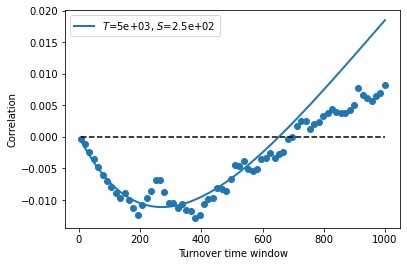

In [18]:
plt.xlabel('Turnover time window')
plt.ylabel('Correlation')
#plt.xlim(0,3.5)
#plt.ylim(-0.1,0.1)
for i in range(len(corrs)):
    plt.scatter(dts, corrs[i])
    plt.plot(dts, corr_th_telegr(dts, 1/t_list[i][0], 1/t_list[i][1]), lw=2, \
             label=r"$T$=%.2g, $S$=%.2g"%(t_list[i][0], t_list[i][1]))
plt.plot(dts, np.zeros(len(dts)),c='black',ls='--')
plt.legend()

In [23]:
s_list = np.logspace(-2.99,np.log10(0.1),15)
N = 1000
mu = 1/1000/50
dts = [50,200]
R = 100000

def compute_heatmap():
    corrs = np.zeros((len(s_list),len(s_list),len(dts)))
    for i_r, s_r in enumerate(s_list):
        for i_v, s_v in enumerate(s_list):
            est_r, est_v = est_time(mu, N, s_r), est_time(mu, N, s_v)
            sw_r, sw_v = sw_time(mu, N, s_r), sw_time(mu, N, s_v)
            dt_traj = min(est_r, est_v, sw_r, sw_v)/10
            t0 = 7*(est_r+est_v+sw_r+sw_v)
            corrs_aux = generate_corr_telegr(est_r, est_v, sw_r, sw_v, dts, R, dt_traj, t0)
            corrs[i_r][i_v] = corrs_aux
    print(s_r)
    return corrs

%time corrs = compute_heatmap()

0.1
CPU times: user 7h 5s, sys: 1.98 s, total: 7h 7s
Wall time: 7h 6s


In [25]:
%time corrs2 = compute_heatmap()

0.1
CPU times: user 7h 1min 17s, sys: 644 ms, total: 7h 1min 17s
Wall time: 7h 1min 17s


In [26]:
%time corrs3 = compute_heatmap()

0.1
CPU times: user 7h 3min 1s, sys: 830 ms, total: 7h 3min 1s
Wall time: 7h 3min 1s


In [38]:
%time corrs4 = compute_heatmap()

0.1
CPU times: user 11h 57min 47s, sys: 3.11 s, total: 11h 57min 50s
Wall time: 11h 57min 50s


In [42]:
corrs5 = np.zeros((len(s_list), len(s_list), 2))
corrs5[:,:,0] = np.loadtxt("corrs50.txt")
corrs5[:,:,1] = np.loadtxt("corrs51.txt")
corrs6 = np.zeros((len(s_list), len(s_list), 2))
corrs6[:,:,0] = np.loadtxt("corrs60.txt")
corrs6[:,:,1] = np.loadtxt("corrs61.txt")

In [43]:
corr_fin = (corrs+corrs2+corrs3+corrs4+corrs5+corrs6)/6

In [44]:
max_abs_corr

0.1097814394706631

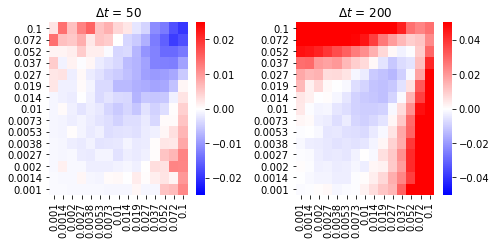

In [46]:
fig, axs = plt.subplots(1,len(dts),figsize=(3.5*len(dts),3.5))
s_list_label = ["%3.2g"%s for s in s_list]

#for i_t, dt in enumerate(dts):
i_t, dt = 0, dts[0]
max_abs_corr = np.max([abs(np.min(corrs[:,:,i_t])), abs(np.max(corrs[:,:,i_t]))])
axs[i_t].set_title(r'$\Delta t$ = '+str(dt))
sns.heatmap(corr_fin[:,:,i_t], ax=axs[i_t],
            vmin=max_abs_corr, vmax=-max_abs_corr, cmap='bwr',
            xticklabels=s_list_label, yticklabels=s_list_label)
axs[i_t].invert_yaxis()
    
i_t, dt = 1, dts[1]
max_abs_corr = np.max([abs(np.min(corrs[:,:,i_t])), abs(np.max(corrs[:,:,i_t]))])
axs[i_t].set_title(r'$\Delta t$ = '+str(dt))
sns.heatmap(corr_fin[:,:,i_t], ax=axs[i_t],
            vmin=0.05, vmax=-0.05, cmap='bwr',
            xticklabels=s_list_label, yticklabels=s_list_label)
axs[i_t].invert_yaxis()

plt.tight_layout()
plt.savefig('corr_heatmap.svg')

In [11]:
s_list = np.logspace(-2,np.log10(0.5),20)
N = 1000
mu = 1/1000/10
dts = [50,100,200]
R = 500000

corrs_s = np.zeros((len(s_list),len(dts)))
for i, s in enumerate(s_list):
    est, sw = est_time(mu, N, s), sw_time(mu, N, s)
    dt_traj = min(est, sw)/15
    t0 = 15*(est+sw)
    corrs_aux = generate_corr_telegr(est, est, sw, sw, dts, R, dt_traj, t0)
    corrs_s[i] = corrs_aux
    print(s)

0.01
0.012286253559934778
0.015095202653900994
0.018546348734442802
0.022786514316233974
0.027996089263633433
0.034396705137956805
0.04226066409512487
0.051922523468393586
0.06379332888043475
0.07837810140573315
0.09629732274171175
0.11831333243475442
0.14536276018142485
0.17859637297609765
0.2194280323269018
0.2695948443325881
0.33123106159213234
0.40695888096473093
0.5


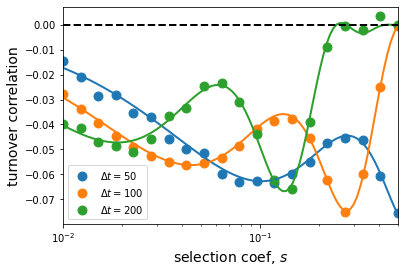

In [12]:
plt.xscale('log')
plt.xlabel(r'selection coef, $s$', fontsize=14)
plt.ylabel(r'turnover correlation', fontsize=14)
plt.xlim(s_list[0],s_list[-1])
x = np.logspace(np.log10(s_list[0]), np.log10(s_list[-1]), 100)

for i_t, dt in enumerate(dts):
    plt.scatter(s_list, corrs_s[:,i_t], s=80, label=r'$\Delta t=$%i'%dt)
    est_rate = 1/est_time(mu, N, x)
    sw_rate = 1/sw_time(mu, N, x)
    c = [corr_th_telegr(dt, est_rate[i], sw_rate[i]) for i in range(len(est_rate))]
    plt.plot(x, c, lw=2)
plt.plot(x, np.zeros(len(x)), color='black', ls='--', lw=2)
plt.legend()
plt.savefig('corr_vs_s2.svg')

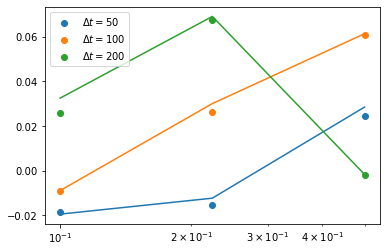

In [26]:
plt.xscale('log')
for i_t, dt in enumerate(dts):
    plt.scatter(s_list, corrs_s[:,i_t], label=r'$\Delta t=$%i'%dt)
    est_rate = 1/est_time(mu, N, s_list)
    sw_rate = 1/sw_time(mu, N, s_list)
    c = [corr_th_telegr(dt, est_rate[i], sw_rate[i]) for i in range(len(est_rate))]
    plt.plot(s_list, c)
plt.legend()